# Comparing ground sensors and satellite observations

In this exercise we will explore data collected by Arable Mark sensors deployed in Zambia, and see how measurements collected by these compare to various satellite observations, which in this case will be three datasets collected from Google Earth Engine:

1. CHIRPS precipitation
2. Sentinel 2 surface reflectance (converted to vegetation indices)
3. MODIS Land Surface Temperature

These comparisons will provide us with some initial insights into the types of detailed, high frequency information that these sensors can provide, and how they might be used to complement and enhance (e.g. through calibration) remote observations.


In [1598]:
import arablepy
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import numpy as np

from datetime import date
from datetime import datetime as dt

today = date.today()
#d1 = today.strftime("%Y-%m-%d")
d1 = "2022-03-28"

import matplotlib.pyplot as plt

import ee
import geemap
# import contextily as cx

# Arable sensor data
## Setup 
### Create client
Enter email and password provided

In [4]:
email = 'email'
password = 'pw'

Connect to the client

In [3]:
client = arablepy.ArableClient()
client.connect(email=email, password=password)

### List available datasets

What datasets are available through the API? The following provides a list of the datasets. 

In [5]:
client.schema(df=True)

,0
0,aux_raw
1,daily
2,health
3,hourly
4,irrigation_runtime_daily
5,irrigation_runtime_hourly
6,local_hourly
7,location_irrigation_forecast_daily
8,sentek_daily
9,sentek_hourly


The daily dataset provides these variables:

In [377]:
client.schema('daily', df=True)

,column_name,data_type,description
0,cl,real,Chlorophyll Index (unitless index)
1,crop_water_demand,real,Crop water demand (mm/day)
2,device,text,"Arable device ID (e.g., A000176)"
3,dli,real,Daily Light Integral
4,ea,double precision,Actual Water Vapor Pressure (kPa)
5,et,real,Evapotranspiration (ETo) (mm)
6,etc,double precision,Crop Evapotranspiration (mm)
7,kc,double precision,"Crop coefficient, Kc (unitless)"
8,lat,real,Latitude (decimal degree)
9,lfairdelta,real,Leaf to air temperature difference (C)


### List available devices

We are going to work with data from our project in Zambia, so we need to get a list of devices first. 

In [6]:
vars = ['current_location', 'name', 'last_seen', 'state', 'batt_pct', 
        'signal_strength']
devices = client.devices(df=True, locations = True, limit=4000)[vars]

We need to go a little extra work to get the devices coordinates and countries. We have devices in both Kenya and Tanzania.

In [7]:
locations = []
for idx, row in devices.iterrows():
    loc = row['current_location']
    gps = loc.get('gps')
    if gps is None:
        gps = [np.isnan, np.isnan]
    country = loc.get('country')
    name = loc.get('device_name')
    locations.append({
        'row': idx, 'name': name, 'country': country, 'x': gps[0], 
        'y': gps[1]
    })
locations = pd.DataFrame(locations)
devices = locations.merge(devices.drop('current_location', axis = 1), 
                          on='name', how='left')

#### Convert to geodataframe

In [8]:
# drop some missing records first, and one in US
devices = devices.mask(devices.eq('None')).dropna()
devices = devices[devices['country'] != 'US']

devices_gdf = gpd.GeoDataFrame(
    devices, geometry=gpd.points_from_xy(devices['x'], devices['y'])
).set_crs(4326, allow_override=True)

#### Plot device locations

Get map center first

In [9]:
%%capture
def minmax(centroid):
    return np.percentile(centroid, [0, 100])
xy = [np.mean(minmax(devices_gdf.centroid.y)), 
      np.mean(minmax(devices_gdf.centroid.x))]

Initialize EarthEngine

First, from your terminal run this and follow the steps
```bash
earthengine authenticate
```

That will give you a code after asking which google account you want to use and whether to trust this. Work through those steps.

Then run this: 

In [10]:
ee.Initialize()

In [11]:
devices_ee = geemap.geopandas_to_ee(devices_gdf)  # gpd to ee
Map = geemap.Map(center=xy, zoom=5)
Map.add_basemap('HYBRID')
Map.addLayer(devices_ee, {'color': 'red'}, "Mark locations")
Map

Map(center=[-8.25767, 32.3134095], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

#### Subset to active devices in Zambia

Those in Zambia

In [12]:
zam_devices = devices_gdf[
    (devices_gdf['country'] == "ZM") & (devices_gdf['y'] < 0)
]
zam_devices

,row,name,country,x,y,last_seen,state,batt_pct,signal_strength,geometry
3,3,A000784,ZM,28.249281,-15.54972,2022-03-24T01:24:10.390404+00:00,Active,7.00,Very Good,POINT (28.24928 -15.54972)
8,8,A000709,ZM,28.249519,-15.54956,2022-03-24T01:18:30.110501+00:00,Active,30.00,Very Good,POINT (28.24952 -15.54956)
13,13,A000721,ZM,28.249331,-15.54972,2022-03-24T00:59:25.032879+00:00,Active,12.00,Very Good,POINT (28.24933 -15.54972)
14,14,A000415,ZM,28.249531,-15.54954,2022-03-24T01:10:00.929122+00:00,Active,14.00,Very Good,POINT (28.24953 -15.54954)
25,25,A000708,ZM,27.07257,-16.83851,2021-02-11T17:39:25.068081+00:00,Dormant,87.00,Very Good,POINT (27.07257 -16.83851)
27,27,A000414,ZM,28.249281,-15.54796,2020-10-17T12:49:01.538957+00:00,Dormant,10.00,Good,POINT (28.24928 -15.54796)
48,48,A000421,ZM,28.249439,-15.54783,2020-10-26T07:54:06.972652+00:00,Dormant,6.00,Very Good,POINT (28.24944 -15.54783)
53,53,A000299,ZM,28.24929,-15.54802,2020-11-20T16:20:23.037023+00:00,Dormant,93.00,Weak,POINT (28.24929 -15.54802)
66,66,A000228,ZM,27.07273,-16.83845,2021-01-14T18:47:21.617063+00:00,Dormant,44.00,Very Good,POINT (27.07273 -16.83845)
70,70,A000292,ZM,28.494381,-14.39462,2020-12-16T14:33:58.556577+00:00,Dormant,16.00,Very Good,POINT (28.49438 -14.39462)


## Collect data from devices

In [1461]:
active_devices = zam_devices[zam_devices['last_seen'] > '2022-01-01']
# active_devices = zam_devices[zam_devices['last_seen'] > '2021-01-01']

devnames = [name for name in active_devices['name']]
daily_df = client.data('daily', devices=devnames, start_time='2021-10-01', 
                       end_time=d1, df=True)
# daily_df = client.data('daily', devices=devnames, start_time='2020-10-01', 
#                        end_time='2021-06-01', df=True)

Reorder the columns to move the device name, location, and observation time to the left hand side

In [1462]:
names = daily_df.columns.values
firstnames = ['device', 'lat', 'long', 'time']
names_reorder = firstnames
[names_reorder.append(name) for name in names if name not in firstnames]
daily_df = daily_df[names_reorder]
daily_df = daily_df.convert_dtypes()  # convert datatypes
daily_df['time'] = pd.to_datetime(daily_df['time']).dt.date

Let's count how many observations per device 

In [1463]:
daily_df[['device', 'time']].groupby(['device']).count()

,time
device,
A000301,125
A000407,82
A000408,126
A000415,128
A000434,137
A000477,92
A000693,119
A000709,130
A000721,135


### Explore sensor data

And let's make a plot for each device for rainfall and a VI

#### Rainfall

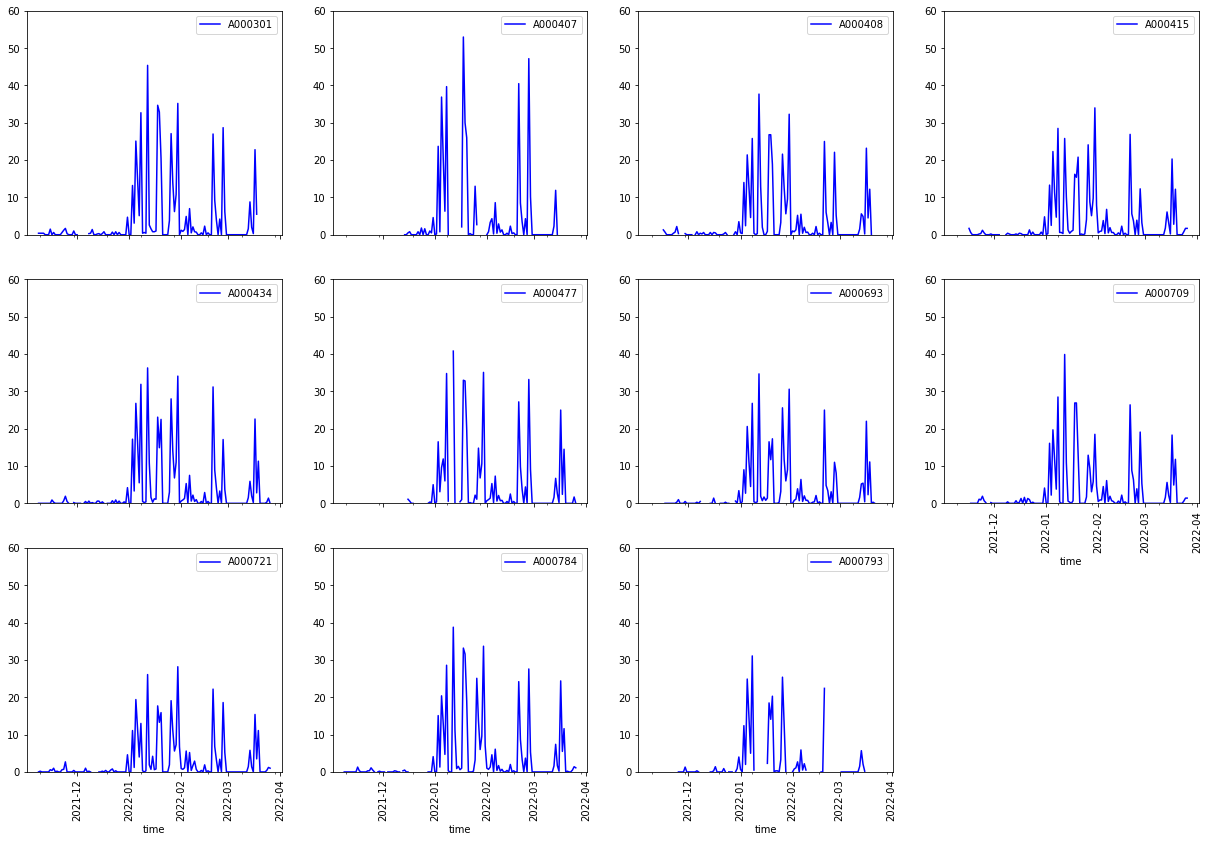

In [1140]:
active_devnames = np.unique(active_devices['name'])
nrow = 3 
ncol = int(np.ceil(len(active_devnames) / nrow))

pd.pivot_table(
    daily_df.reset_index(), index='time', columns='device', values='precip'
).plot(
    subplots=True, layout=(nrow, ncol), figsize=(21, 14), color='blue', rot=90,
    ylim=(0, 60)
)
None

#### NDVI

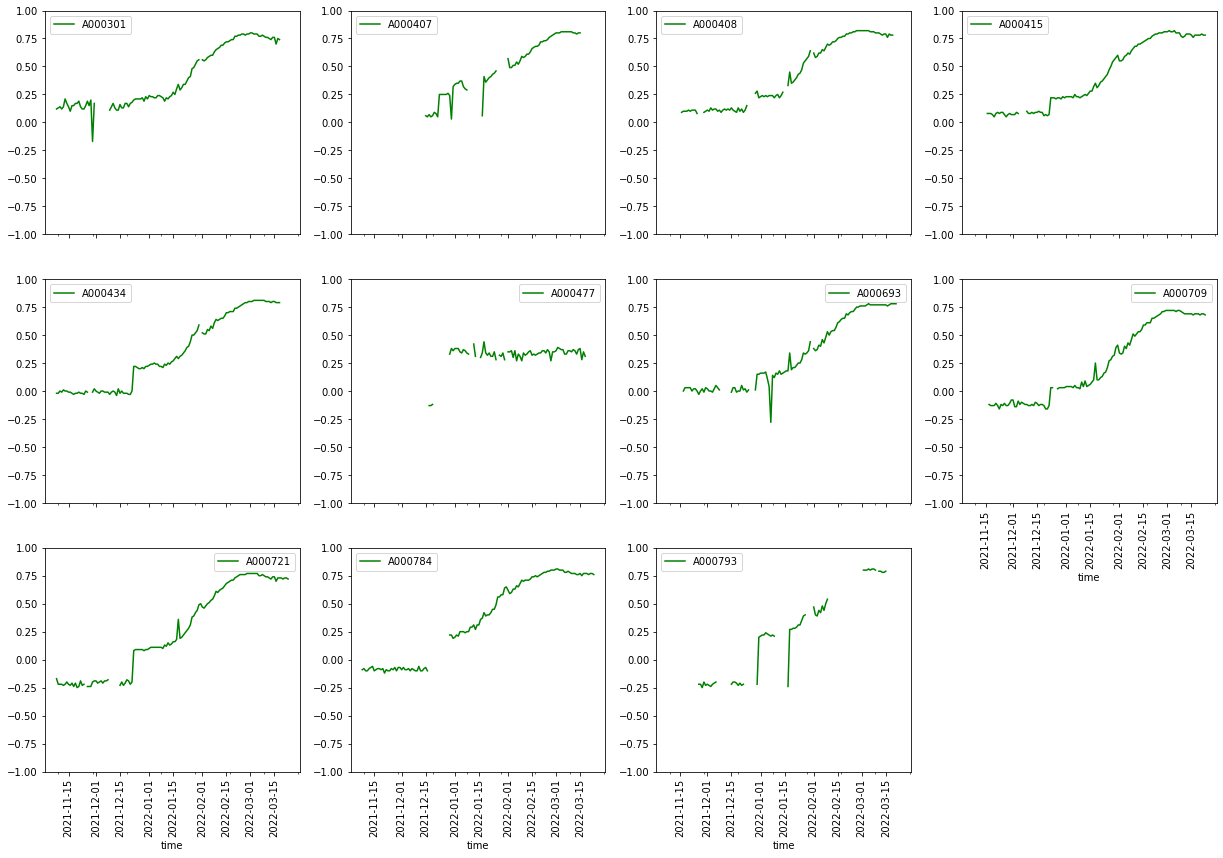

In [34]:
pd.pivot_table(
    daily_df.reset_index(), index='time', columns='device', values='ndvi'
).plot(
    subplots=True, layout=(nrow, ncol), figsize=(21, 14), color='green', 
    rot=90, ylim=(-1, 1)
)
None

#### Max temperature

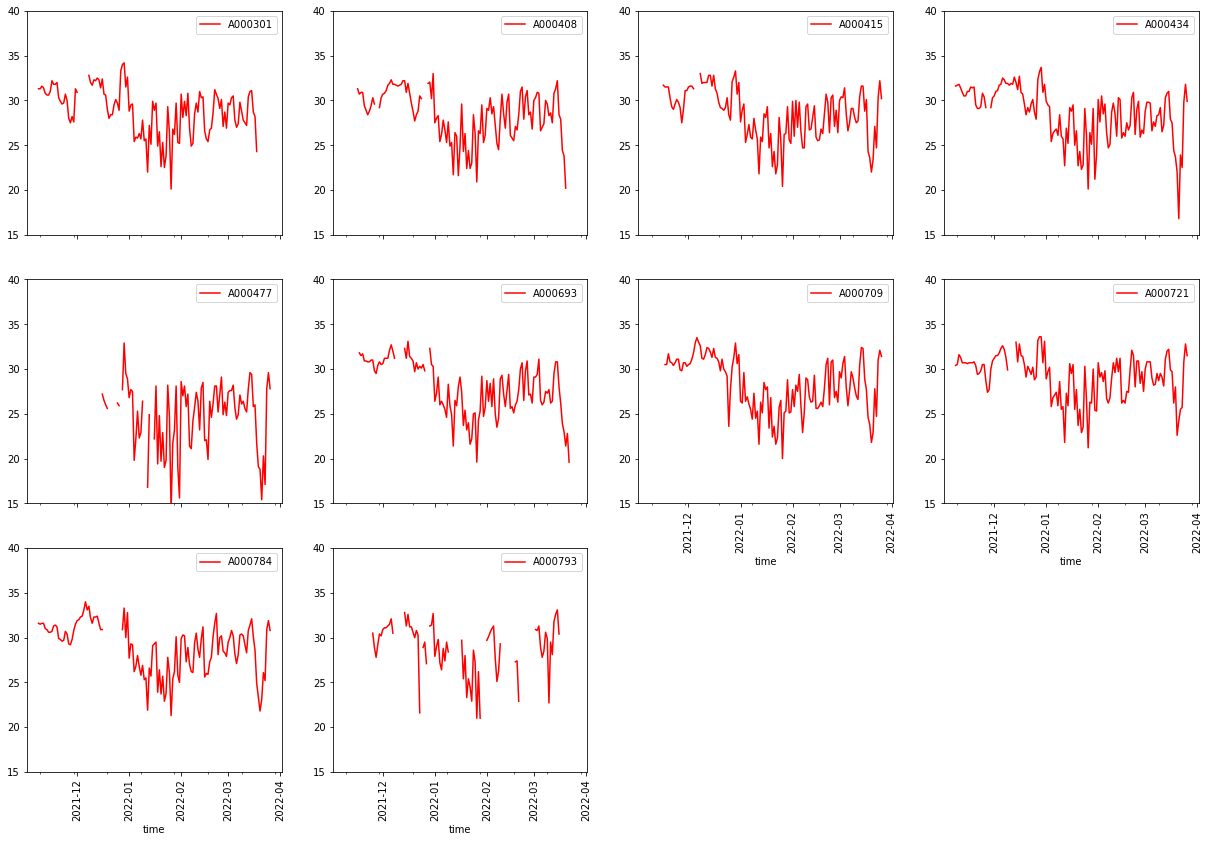

In [1139]:
pd.pivot_table(
    daily_df.reset_index(), index='time', columns='device', values='maxt'
).plot(
    subplots=True, layout=(nrow, ncol), figsize=(21, 14), color='red', 
    rot=90, ylim=(15, 40)
)
None

#### [**Assignment**] Additional plots of sensor variables

Create two more plots:

1. Shortwave downwelling radiation. Use orange for the lines. Use a fixed range for the y-axis for each plot of 0-30
2. Mean surface temperature (temperate below the sensor). Use the color 'darkred' for the line and a y-range of 15-35

In [1583]:
## Answer here

In [1584]:
## Answer here

# Collecting satellite data

For this, we will use the python client for Earth Engine, as well as the `geemap` package

## Image processing functions

We first need to setup some functions to do this. 

### For extracting time series

We need two functions for this. One for CHIRPs and Sentinel-2, and one for MODIS LST, as there is trouble getting the temp variable out using the first function

In [1074]:
def fill(img, ini):
    
    def set_date(ft):
        return ft.set("date", date)   
    
    # type cast
    inift = ee.FeatureCollection(ini);

    # gets the values for the points in the current img
    ft2 = ee.FeatureCollection(img.reduceRegions(fc, ee.Reducer.first(), 30))  
  
    # gets the date of the img
    date = img.date().format();

    # writes the date in each feature
    ft3 = ft2.map(set_date)
    
    # merges the FeatureCollections
    return inift.merge(ft3)

# For MODIS LST
def extract_time_series(img_col, x, y, device, band, delta, sf):
    # adapted from https://gis.stackexchange.com/questions/313186/
    # extracting-pixel-time-series-from-google-earth-engine

    point = ee.Geometry.Point(x, y)

    images = [item.get('id') for item in img_col.getInfo().get('features')]
    store = []
    date_store = []

    for image in images:

        im = ee.Image(image)

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band) \
                 .reduceRegion(ee.Reducer.first(), point, 1)\
                 .get(band)

        store.append(data.getInfo())

    store = [(x * sf) - delta if isinstance(x, int) else np.nan for x in store]
    # df = pd.DataFrame(index=date_store, data=store, columns=band)
    df = pd.DataFrame({'date': date_store, 'device': row.name, band: store})
    df['date'] = pd.to_datetime(df['date']).dt.date
    
    return df


### For processing Sentinel-2 data

In [652]:
# From https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.updateMask(not_cld_shdw).divide(10000) \
              .select('B.*') \
              .copyProperties(img, ["system:time_start"])

### For image display

In [653]:
# this allows you to select an image from a collection by index
def col_to_list(image_collection, index):
    col_list = image_collection.toList(image_collection.size())
    return ee.Image(col_list.get(index))

## Set up study region

Before collecting data, we need to capture more accurate coordinates for our devices (by averaging the GPS coordinates for each device provided over time), and by creating an AOI for image processing in a broader neighborhood around the devices. 

In [654]:
%%capture
# get more accurate coordinates for devices
devices_xy = daily_df[['device', 'lat', 'long']]\
    .groupby('device')\
    .median(['lat', 'long'])\
    .rename(columns={'long': 'x', 'lat': 'y'})

devices_xy_gdf = gpd.GeoDataFrame(
    devices_xy, geometry=gpd.points_from_xy(devices_xy['x'], devices_xy['y'])
).set_crs(4326).drop(['x', 'y'], axis=1)

geom = box(*active_devices.total_bounds + [-0.1, -0.1, 0.1, 0.1])
aoi = gpd.GeoDataFrame({"ID": 1, "geometry": [geom]}).set_crs(4326)
xy = [np.mean(minmax(aoi.centroid.y)), 
      np.mean(minmax(aoi.centroid.x))]

Coerce aoi and devices GeoDataframes to ee object

In [655]:
aoi_ee = geemap.geopandas_to_ee(aoi)  # gpd to ee
devices_xy_ee = geemap.geopandas_to_ee(devices_xy_gdf) 

## Collect data from imagery

### CHIRPs

Cut CHIRPS data down to AOI around sensors

In [656]:
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
           .filterDate('2021-12-15', d1)\
           .filterBounds(aoi_ee)
chirps_aoi = chirps.map(lambda img: img.clip(aoi_ee))

#### Extract rainfall values points

Use our functions to extract the time series of rainfall values from the CHIRPs dataset corresponding to our sensor locations.

In [657]:
ft = ee.FeatureCollection(ee.List([]))
fc = devices_xy_ee
newft = ee.FeatureCollection(chirps_aoi.iterate(fill, ft))

# convert back from ee to pandas
rainfall_ts = geemap.ee_to_pandas(newft)
rainfall_ts = rainfall_ts.rename(columns={"first": "rainfall"})
rainfall_ts['date'] = pd.to_datetime(rainfall_ts['date']).dt.date

Since the pixel is much larger than the points were the pods are, we can just average by date. 

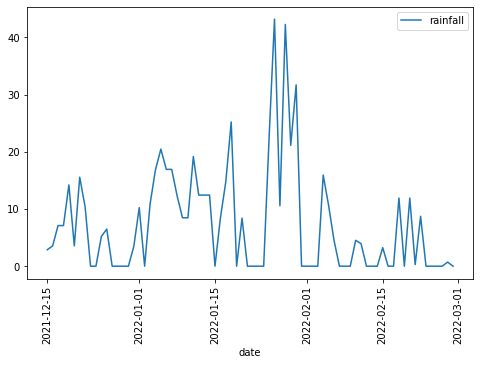

In [658]:
rainfall_ts.groupby('date').mean().plot(rot=90, figsize=(8, 5))
None

### Sentinel 2

#### Load in images and apply cloud/shadow masks

In [659]:
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

s2_sr_cld_col = get_s2_sr_cld_col(aoi_ee, '2021-12-15', d1)

s2_sr_masked = s2_sr_cld_col.map(add_cld_shdw_mask) \
                            .map(apply_cld_shdw_mask)
s2_sr_masked_aoi = s2_sr_masked.map(lambda img: img.clip(aoi_ee))

#### Extract time series from points

In [660]:
ft = ee.FeatureCollection(ee.List([]))
scale=30
newft2 = ee.FeatureCollection(s2_sr_masked_aoi.iterate(fill, ft))

Convert to pandas for further analysis

In [661]:
s2_ts = geemap.ee_to_pandas(newft2)
s2_ts['date'] = pd.to_datetime(s2_ts['date']).dt.date

Examine and remove missing data values

In [662]:
s2_ts.groupby('date').apply(lambda x: x['B1'].isna().sum())

date
2021-12-30     0
2022-01-24     0
2022-01-29    11
2022-02-03    11
2022-02-13    11
2022-02-23    11
2022-02-28    11
2022-03-15    11
dtype: int64

In [663]:
s2_ts = s2_ts.dropna()
s2_ts.groupby('date').apply(lambda x: x['B1'].isna().sum())  # NAs removed

date
2021-12-30    0
2022-01-24    0
2022-01-29    0
2022-02-13    0
2022-02-23    0
2022-02-28    0
2022-03-15    0
dtype: int64

In [669]:
s2_ts

,date,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,device
0,2021-12-30,0.0436,0.0470,0.0765,0.1139,0.1407,0.1755,0.1933,0.1877,0.2123,0.2086,0.2699,0.2268,A000301
1,2021-12-30,0.0436,0.0554,0.0893,0.1438,0.1742,0.1961,0.2059,0.2064,0.2267,0.2086,0.3303,0.2869,A000407
2,2021-12-30,0.0436,0.0470,0.0765,0.1139,0.1407,0.1755,0.1933,0.1877,0.2123,0.2086,0.2699,0.2268,A000408
3,2021-12-30,0.0436,0.0565,0.0891,0.1374,0.1663,0.1965,0.2125,0.2092,0.2219,0.2086,0.3389,0.2954,A000415
4,2021-12-30,0.0436,0.0565,0.0891,0.1374,0.1663,0.1965,0.2125,0.2092,0.2219,0.2086,0.3389,0.2954,A000434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2022-03-15,0.1410,0.1514,0.1726,0.1540,0.1999,0.3582,0.4107,0.3983,0.4219,0.4045,0.2813,0.1981,A000693
128,2022-03-15,0.1410,0.1514,0.1726,0.1540,0.1999,0.3582,0.4107,0.3983,0.4219,0.4045,0.2813,0.1981,A000709
129,2022-03-15,0.1410,0.1469,0.1620,0.1439,0.1799,0.3271,0.3910,0.3768,0.4007,0.4045,0.2479,0.1755,A000721
130,2022-03-15,0.1410,0.1469,0.1620,0.1439,0.1799,0.3271,0.3910,0.3768,0.4007,0.4045,0.2479,0.1755,A000784


### MODIS Land Surface Temperature

Get collection and mask out low quality data, clip to AOI

In [843]:
lst = ee.ImageCollection("MODIS/006/MOD11A1") \
        .filterDate('2021-12-15', d1) \
        .filterBounds(aoi_ee) \
        .select(['LST_Day_1km', 'QC_Day'])

def mask_lst(image):
    mask = image.select('QC_Day').neq(1)
    return image.updateMask(mask)

lst_aoi = lst.map(lambda img: img.clip(aoi_ee)) \
             .map(mask_lst)

#### Extract T values from points

Note that the approach used for CHIRPs and Sentinel-2 doesn't work, as it fails to return to *LST_Day_1km* variable, hence is commented out. We instead use the `extract_time_series` function to do the job, extracting from just a single point (since the pixel size is 1 km one point is sufficient)

In [1150]:
# Approach used for CHIRPS and S2 (doesn't work)
# ft = ee.FeatureCollection(ee.List([]))
# fc = devices_xy_ee#.first()
# newft3 = ee.FeatureCollection(lst_aoi.iterate(fill, ft))

# lst_ts = geemap.ee_to_pandas(newft3)
# lst_ts['date'] = pd.to_datetime(lst_ts['date']).dt.date

# extract_time_series approach, from
row = devices_xy.iloc[7]  # Device A000709
delta = 273.15  # Kelvin offset
sf = 0.02  # scale factor for T conversion to C
band = 'LST_Day_1km'
img_col = lst_aoi

lst_ts = extract_time_series(
    lst_aoi, row['x'], row['y'], row.name, band, delta, sf
).dropna()

In [1151]:
lst_ts

,date,device,LST_Day_1km
1,2021-12-15,A000709,39.79
12,2021-12-26,A000709,29.43
14,2021-12-28,A000709,43.51
17,2021-12-31,A000709,33.59
48,2022-01-31,A000709,26.23
49,2022-02-01,A000709,24.39
60,2022-02-12,A000709,30.69
63,2022-02-15,A000709,28.39
69,2022-02-21,A000709,27.65
71,2022-02-23,A000709,28.77


<AxesSubplot:xlabel='date'>

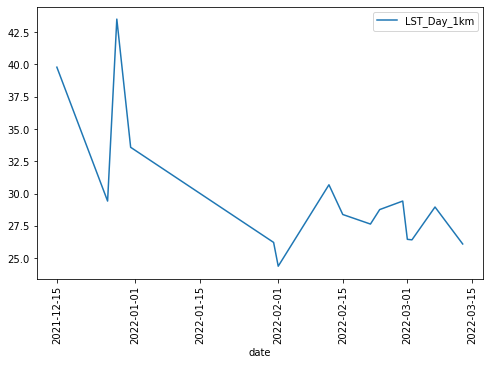

In [1152]:
lst_ts.plot(x='date', y='LST_Day_1km', rot=90, figsize=(8, 5))

In [1153]:
print('Number of images (LST):', lst_aoi.size().getInfo())

Number of images (LST): 100


### Maps

A look at the three datasets we are using relative to the sensor locations. 

In [1154]:
chirps_viz_params = {
    'min': 0,
    'max': 20
}


# Note: MODIS LST is in Kelvin
lst_viz_params = {
    'min': 14400,
    'max': 15700
}

s2_viz_params = {
  'bands': ['B8', 'B4', 'B3'],
  'min': 0,
  'max': 0.5,
  #'gamma': [0.95, 1.1, 1]
}

Map = geemap.Map(center=xy, zoom=12)
Map.add_basemap('HYBRID')
Map.addLayer(col_to_list(chirps_aoi, 10), 
             chirps_viz_params, "CHIRPs")
Map.addLayer(col_to_list(lst_aoi.select('LST_Day_1km'), 1), 
             lst_viz_params, "MODIS LST")
Map.addLayer(col_to_list(s2_sr_masked_aoi, 9), s2_viz_params, 'S2 image')
Map.addLayer(devices_xy_ee, {'color': 'blue'}, "Mark locations")
Map

Map(center=[-15.549735000000004, 28.2494545], controls=(WidgetControl(options=['position', 'transparent_bg'], …

# Sensor-Satellite Comparisons

## Combine datasets

First reduce the sensor dataset a bit.

In [1464]:
keep_cols = [
    'device', 'lat', 'long', 'time', 'swdw', 'maxt', 'mint', 'meant', 
    'mean_tbelow', 'mean_rh', 'ndvi', 'precip' 
]
daily_df = daily_df[keep_cols]
daily_df.rename(columns = {'time': 'date'}, inplace=True)
daily_df

,device,lat,long,date,swdw,maxt,mint,meant,mean_tbelow,mean_rh,ndvi,precip
0,A000784,-15.54789,28.2492,2021-11-08,0.1,31.6,27.5,31.0,29.9,0.66,-0.09,0.0
1,A000784,-15.54789,28.2492,2021-11-09,0.1,31.5,30.2,30.9,29.8,0.64,-0.08,0.0
2,A000784,-15.54789,28.2492,2021-11-10,0.1,31.6,30.1,30.9,30.1,0.65,-0.1,0.0
3,A000784,-15.54789,28.2492,2021-11-11,0.1,31.6,29.9,30.8,29.8,0.73,-0.1,0.0
4,A000784,-15.54789,28.2492,2021-11-12,0.1,31.0,28.7,30.1,29.1,0.76,-0.08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
114,A000693,-15.54951,28.24957,2022-03-18,7.4,23.9,16.1,19.5,21.9,0.95,0.78,2.3
115,A000693,-15.54959,28.24957,2022-03-19,5.6,23.0,16.3,19.3,21.6,0.95,0.78,11.1
116,A000693,-15.54959,28.24957,2022-03-20,4.3,21.4,15.5,18.3,20.6,0.96,0.78,0.0
117,A000693,-15.54959,28.24957,2022-03-21,7.0,22.8,14.2,18.0,20.6,0.92,0.78,0.3


Then merge with the three satellite datasets. We'll make one dataset combining sensor data with MODIS and CHIRPs data, and a separate one combining sensors and Sentinel-2. 

For the first one, we will use data from sensor A000709, the same used to collect MODIS LST data

In [1471]:
daily_lstrf = daily_df[daily_df['device'] == 'A000709'].merge(  
    rainfall_ts[rainfall_ts['device'] == 'A000709'], # CHIRPS data
    how='left', on=['device', 'date']
).merge(lst_ts, how='left') 

# convert to date for filtering
daily_lstrf['date'] = pd.to_datetime(daily_lstrf['date']) # convert to date

# remove observations before 2021-12-15
daily_lstrf.query("date >= '2021-12-15'", inplace=True)
daily_lstrf

,device,lat,long,date,swdw,maxt,mint,meant,mean_tbelow,mean_rh,ndvi,precip,rainfall,LST_Day_1km
28,A000709,-15.54787,28.24933,2021-12-15,0.1,31.3,29.1,30.2,30.3,0.41,-0.11,0.0,2.800844,39.79
29,A000709,-15.54793,28.24927,2021-12-16,0.1,32.3,28.9,30.4,30.8,0.4,-0.13,0.3,3.531434,NaN
30,A000709,-15.54793,28.24927,2021-12-17,0.1,31.3,29.9,30.6,29.7,0.48,-0.12,1.3,7.062869,NaN
31,A000709,-15.54797,28.24927,2021-12-18,0.1,31.2,28.9,30.1,29.3,0.48,-0.12,0.0,7.062869,NaN
32,A000709,-15.54794,28.24924,2021-12-19,0.1,30.8,28.2,29.6,28.7,0.49,-0.13,1.6,14.125737,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,A000709,-15.54956,28.24952,2022-03-22,9.1,27.8,14.2,18.7,21.6,0.82,0.69,0.0,NaN,NaN
126,A000709,-15.54956,28.24952,2022-03-23,7.7,24.7,15.5,19.2,22.1,0.82,0.68,0.0,NaN,NaN
127,A000709,-15.54955,28.24952,2022-03-24,9.1,31.0,17.0,22.0,24.5,0.84,0.69,0.6,NaN,NaN
128,A000709,-15.54955,28.24952,2022-03-25,12.5,32.1,17.0,22.8,25.3,0.79,0.7,1.4,NaN,NaN


For the Sentinel time series, we will keep data from all sensors.

In [1556]:
daily_s2 = daily_df[['device', 'date', 'ndvi']].merge(s2_ts, how="left", on=['device', 'date'])

# convert to date for filtering
daily_s2['date'] = pd.to_datetime(daily_s2['date']) 

# remove observations before 2021-12-15
daily_s2.query("date >= '2021-12-15'", inplace=True)
daily_s2

,device,date,ndvi,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12
37,A000784,2021-12-15,-0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,A000784,2021-12-16,-0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,A000784,2021-12-16,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,A000784,2021-12-28,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,A000784,2021-12-29,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,A000693,2022-03-18,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1277,A000693,2022-03-19,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1278,A000693,2022-03-20,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1279,A000693,2022-03-21,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notice there are a lot of NA values in S2 bands, because we masked out cloudy pixels. We can see the dates with valid S2 values by dropping the NA records. 

In [1557]:
daily_s2.dropna()

,device,date,ndvi,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12
42,A000784,2021-12-30,0.22,0.0436,0.0470,0.0765,0.1139,0.1407,0.1755,0.1933,0.1877,0.2123,0.2086,0.2699,0.2268
67,A000784,2022-01-24,0.45,0.0606,0.0650,0.0997,0.1069,0.1556,0.2798,0.3181,0.2970,0.3371,0.3238,0.3015,0.2295
72,A000784,2022-01-29,0.58,0.1413,0.1412,0.1705,0.1599,0.2119,0.3329,0.3613,0.3501,0.3795,0.3407,0.2978,0.2164
87,A000784,2022-02-13,0.71,0.1363,0.1418,0.1656,0.1509,0.2011,0.3622,0.4148,0.4101,0.4226,0.3699,0.3162,0.2350
97,A000784,2022-02-23,0.78,0.1605,0.1621,0.1868,0.1560,0.2152,0.4330,0.5145,0.5069,0.5231,0.4823,0.3330,0.2281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,A000693,2022-01-29,0.36,0.1413,0.1462,0.1741,0.1825,0.2235,0.2815,0.2941,0.2941,0.3058,0.3407,0.3343,0.2662
1243,A000693,2022-02-13,0.54,0.1363,0.1435,0.1669,0.1763,0.2133,0.2969,0.3309,0.3231,0.3457,0.3699,0.3643,0.3028
1253,A000693,2022-02-23,0.71,0.1605,0.1661,0.1949,0.1821,0.2335,0.3996,0.4572,0.4481,0.4749,0.4823,0.3808,0.2771
1258,A000693,2022-02-28,0.76,0.1439,0.1379,0.1738,0.1557,0.2149,0.4080,0.4592,0.4429,0.4796,0.4877,0.3317,0.2292


Now that we have our merged datasets, we will do some graphical comparisons to start.  

## Rainfall comparison

### Compare the time series

Let's first compare each time series on the same plot

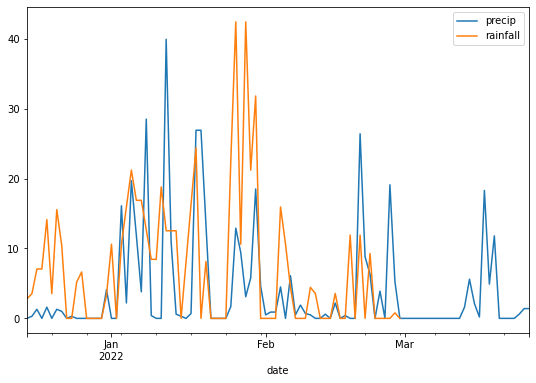

In [1475]:
daily_lstrf.plot(x='date', y=['precip', 'rainfall'], figsize=(9, 6))
None

Notice the CHIRPS data (rainfall) only go up until early March, which reflects the fact that the data have not yet been ingested into the Earth Engine catalog.

### Plot the daily differences

Now let's calculate the difference between the sensor's measurement (precip) and the CHIRPs variable

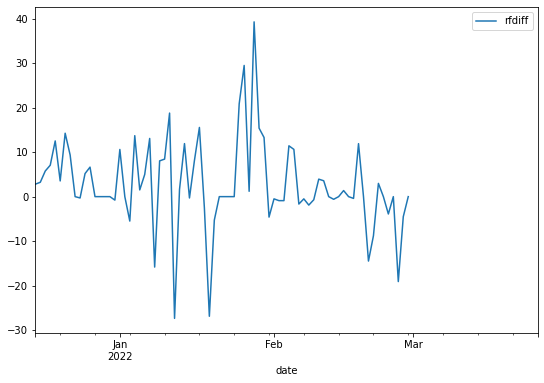

In [1476]:
rfdiff = daily_lstrf[['date', 'precip', 'rainfall']].assign(
    rfdiff = lambda x: (x['rainfall'] - x['precip'])  # calculate difference
)
rfdiff.plot(x='date', y='rfdiff', figsize=(9, 6))
None

We made a new dataframe with a variable *rfdiff* that represents the difference between the CHIRPs dataset and the sensor rainfall. The plot shows the differences can be quite large, both in the negative and positive direction.  

### Calculate the mean absolute difference

And how much that is as a percent of sensor average daily rainfall

In [1578]:
mad = rfdiff.dropna()['rfdiff'].abs().mean()  # mean absolute difference
mu = rfdiff.dropna()['precip'].mean()  # sensor mean daily rainfall
pct = mad / mu * 100   # MAD as percent of mean daily rainfall

print(f'The mean absolute difference is {mad} mm, which is {pct} of the sensor average rainfall')

The mean absolute difference is 6.583989572681879 mm, which is 139.92819002344038 of the sensor average rainfall


So the difference in rainfall measurements between the sensors and the CHIRPs is quite substantial. We can see this in another way by making a scatter plot of the sensor and CHIRPs rainfall

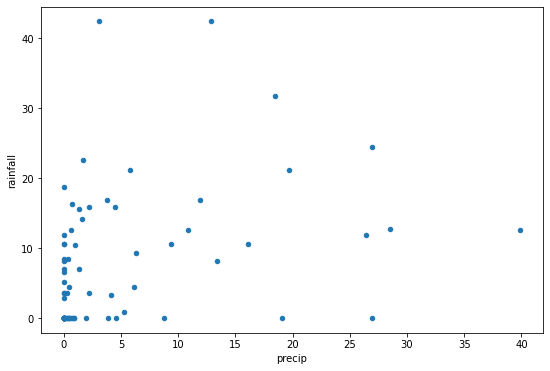

In [1283]:
rfdiff.plot(x='precip', y='rainfall', kind='scatter', figsize=(9, 6))
None

If the measurements agreed with one another, they would fall much more closely along the "1:1 line" on the plot diagonal.  One reason for these discrepancies is measurement error in both systems. Another likely reflects the scale of measurement provided by each. The sensor is a point-based measurement, whereas CHIRPs is using satellites and models to estimate daily rainfall averaged within a 5X5 km pixel. That's a pretty big area, and the amount of rainfall can vary quite substantially over fairly short distances (e.g. a few hundred meters). That might also explain the difference. One way we might make the measurement scales more comparable is by comparing the two measurements over longer time scales, i.e. the total amount of rainfall falling in a week or a month. Under this logic, the sensor measurements might start to be more similar to the satellite estimate because the variability received at a point over time might start to resemble the variability experienced in the 5X5 km box around it during that time period. Let's have a look at whether this possibility is realized here. 

To do that, we want to average the sensor and satellite measurements by week. 

### Compare average weekly rainfall **[assignments]**

In [1342]:
# create new variable defining the week of the year
rfdiff['week'] = rfdiff['date'].dt.strftime('%W')
rfdiff['year'] = rfdiff['date'].dt.strftime('%Y')

# calculate the sum of rainfall and precip for each week
rfweek = rfdiff.drop('rfdiff', axis=1).dropna() \
               .groupby(['year', 'week']).mean() \
               .reset_index() \
               .assign(
                    rfdiff = lambda x: (x['rainfall'] - x['precip'])
                )
rfweek

,year,week,precip,rainfall,rfdiff
0,2021,50,0.64,6.916750,6.27675
1,2021,51,0.371429,5.897548,5.526119
2,2021,52,0.82,0.663691,-0.156309
3,2022,00,0.0,5.303111,5.303111
4,2022,01,11.8,14.657086,2.857086
5,2022,02,7.385714,10.420205,3.034491
6,2022,03,9.7,6.967916,-2.732084
7,2022,04,7.342857,24.422916,17.080059
8,2022,05,2.5,4.426797,1.926797
9,2022,06,0.6,1.142872,0.542872


So that's what it looks like at a weekly timestep. Now, on your own, do the following:

1. Make a scatter plot of the weekly average precip against rainfall, as we did with the daily rainfall
2. Calculate the mean absolute difference between the two datasets, as we did with the daily values, including its percent difference relative to the mean sensor weekly rainfall 

Spots to place your answers are below. Provide a very brief explanation of what you find in terms of how the differences compare to the daily rainfall values. e.g. Do we see more convergence at the weekly time scale? 

#### **[Assignment]** Plot weekly means of sensor rainfall vs CHIRPs

In [1585]:
## Place answer here

#### **[Assignment]** Calculate mean absolute difference between weekly mean sensor and CHIRPs rainfall 

In [1587]:
## Place answer here

## Temperature comparison

Now we will move onto the comparions of temperature between sensor temperatures and MODIS LST

### Max temperature

Let's start with maximum temperature, since we are using the MODIS day LST, which is close to daily maximum temperature since it is collected near noon

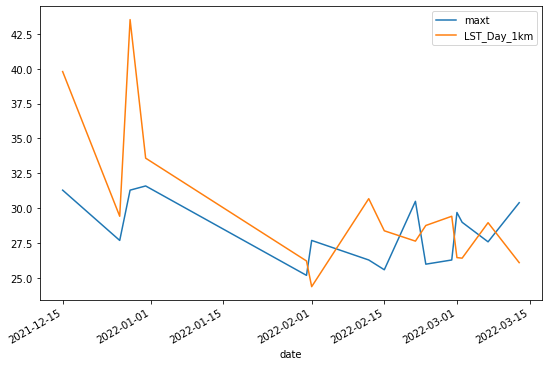

In [1388]:
# first drop dates with no MODIS values
daily_lst = daily_lstrf.dropna(axis=0, subset=['LST_Day_1km'])

# then plot
daily_lst.plot(x='date', y=['maxt', 'LST_Day_1km'], figsize=(9, 6))
None

Looks like a pretty reasonable correspondence. As with the rainfall, we can calculate the difference between sensor maxt and MODIS LST, by assigning a new variable *maxtdiff*, which is the difference between *maxt* and *LST_Day_1km*. 

In [1404]:
daily_lst = daily_lst.assign(maxtdiff = lambda x: x['maxt'] - x['LST_Day_1km'])
daily_lst

,device,lat,long,date,ea,et,etc,swdw,maxt,mint,...,mean_tbelow,mean_rh,ndvi,precip,rh_at_maxt,rh_at_mint,vpd,rainfall,LST_Day_1km,maxtdiff
28,A000709,-15.54787,28.24933,2021-12-15,1.76,1.6,0.0,0.1,31.3,29.1,...,30.3,0.41,-0.11,0.0,0.43,0.42,2.5,2.800844,39.79,-8.49
39,A000709,-15.54953,28.24956,2021-12-26,1.94,0.5,<NA>,1.7,27.7,20.4,...,26.3,0.67,<NA>,0.0,0.52,0.8,1.0,6.636906,29.43,-1.73
41,A000709,-15.54957,28.24957,2021-12-28,1.72,3.7,0.0,16.4,31.3,18.8,...,29.0,0.56,0.03,0.0,0.35,0.71,1.5,0.000000,43.51,-12.21
44,A000709,-15.54956,28.24956,2021-12-31,1.97,2.3,0.0,9.4,31.6,18.6,...,26.8,0.67,0.03,4.1,0.4,0.72,1.0,3.318453,33.59,-1.99
75,A000709,-15.54953,28.24952,2022-01-31,2.15,0.6,0.2,2.4,25.2,15.5,...,21.9,0.91,0.41,4.6,0.77,1.0,0.3,0.000000,26.23,-1.03
76,A000709,-15.54953,28.24952,2022-02-01,2.03,3.3,1.1,16.0,27.7,17.5,...,25.4,0.76,0.34,0.5,0.54,0.84,0.7,0.000000,24.39,3.31
87,A000709,-15.54955,28.24957,2022-02-12,1.97,2.6,1.6,13.1,26.3,16.8,...,24.5,0.82,0.53,0.0,0.57,1.0,0.5,0.000000,30.69,-4.39
90,A000709,-15.54958,28.24948,2022-02-15,1.97,2.4,1.6,11.8,25.6,16.5,...,24.2,0.82,0.59,2.2,0.64,1.0,0.5,3.565894,28.39,-2.79
96,A000709,-15.54953,28.24953,2022-02-21,2.24,2.7,2.1,11.2,30.5,17.6,...,25.1,0.83,0.65,8.8,0.54,1.0,0.6,0.000000,27.65,2.85
98,A000709,-15.54953,28.24957,2022-02-23,1.96,3.0,2.4,14.0,26.0,17.2,...,24.4,0.81,0.67,0.0,0.62,0.96,0.5,0.000000,28.77,-2.77


And we can plot these two variables against each other and calculate the MAD and its percentage relative to mean *maxt*

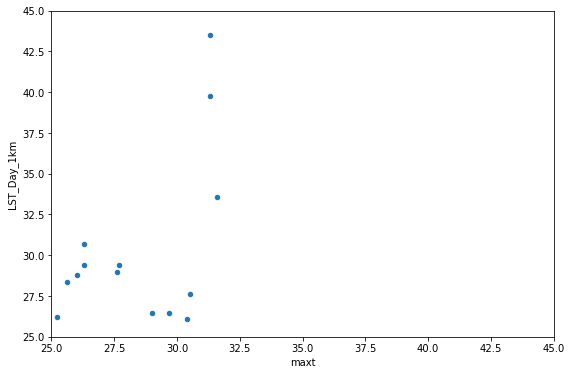

In [1410]:
daily_lst.plot(x='maxt', y='LST_Day_1km', kind='scatter', figsize=(9, 6), 
               xlim=(25, 45), ylim=(25, 45))
None

In [1597]:
mad = daily_lst['maxtdiff'].abs().mean()  # mean absolute difference
mu = daily_lst['maxt'].mean()  # sensor mean maxt
pct = mad / mu * 100   # MAE as percent of mean maxt

print(f'The mean absolute difference is {mad} degrees, which is {pct} % of the sensor average daily max temperature')

The mean absolute difference is 3.7433333333333443 degrees, which is 13.1745659314876 % of the sensor average daily max temperature


### Daily mean below sensor temperature **[assignments]**

The MODIS LST is much closer to the sensor temperature. Now let's compare MODIS to the sensor's reading of temperature *below* it (i.e. the surface temperature). The previous comparison is the sensor's estimate of air temperature.  For this, you will need to:

1. Plot the time series of daily mean temperature below the sensor (look at the table of available daily data variables to find the right variable) and the *LST_Day_1km* variable on the same plot (use the `daily_lst` dataset for this)
2. Calculate and add a new variable *tbelowdiff* to the `daily_lst` dataset, subtracting the *LST_Day_1km* variable from the daily mean temperature below variable
3. Make a scatter plot of the two variables (daily mean temperature below, *LST_Day_1km*) against each other
4. Calculate the MAD between and its percent difference relative to the daily mean temperature below

#### **[Assignment]** Plot time series of daily mean temperature below sensor and LST

In [1588]:
## Insert answer here

#### **[Assignment]** Calculate *tbelowdiff* variable

In [1589]:
## Answer here

#### **[Assignment]** Scatter plot of mean temperature below sensor versus MODIS LST

Make sure you adjust the xlim and ylim to show the full range of data

In [1590]:
## Answer here

#### **[Assignment]** Calculate mean absolute difference between mean below sensor temperature and MODIS LST

As well as its percent difference relative to mean below sensor temperature

In [1591]:
## Answer here

## Sentinel-2 vegetation index comparisons **[assignments]**

We'll now switch to the second of our two datasets that compares daily sensor data to Sentinel-2 band values. This work will be done as an assignment (with a pointer or two for guidance) with the following tasks:

1. Calculate NDVI from the relevant S2 bands, adding it as a new variable (call it *s2_ndvi*) to the `daily_s2` dataset 
2. Plot the sensor NDVI and S2 NDVI variables time series against one another
3. Make a scatter plot of sensor NDVI and S2 NDVI
4. Calculate the difference between sensor NDVI and S2 NDVI (call the new variable *ndvidiff*)
5. Calculate the MAD from *ndvidiff* and its percent difference relative to sensor NDVI

### **[Assignment]** Calculate S2 NDVI

Remember that NDVI is a ratio between the NIR and red channels. You can use the following function to help you:

In [1558]:
def ndvi(nir, red):
    return (nir - red) / (nir + red)

Pass that function into the `assign` function to create a new *s2_ndvi* variable in a new `s2_ndvi` dataframe (after the `lambda x:` part). Remember to use the correct bands from S2 to make NDVI.

In [1592]:
## Answer here

### Plot sensor and S2 NDVI as time series

Start by plotting NDVI for device A000709. Note we add the marker argument to enable the plots to be visible for both *s2_ndvi*, which has many NA values because of cloud cover, and *ndvi*, which is not affected by cloud.

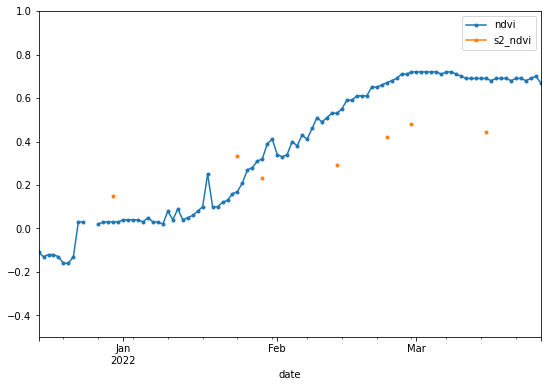

In [1560]:
s2_ndvi.query("device=='A000709'") \
       .plot(x='date', y=['ndvi', 's2_ndvi'], ylim=(-0.5, 1), marker='.',
            figsize=(9,6))
None

### **[Assignment]** Plot sensor and S2 NDVI for device A000693

In [1594]:
## Answer here

### **[Assignment]** Make a scatter plot of S2 and sensor NDVI

Make the plot for values from device A00693. Make the xlim and ylim of each plot both (0,1)

In [1595]:
## Answer here

### **[Assignment]** Calculate *ndvidiff*, the difference in sensor and S2 NDVI

This can be calculated across all devices (in other words, you don't need to query for a specific device)

In [1596]:
## Answer here

### **[Assignment]** Now calculate the MAD between sensor and S2 NDVI

As well as it's percentage. To do this, we will want to drop NA values from the dataframe by first appending `.dropna` to `s2_ndvi`, e.g. `s2_ndvi.dropna()['ndvidiff].`

In [1593]:
## Answer here